# Inductive Conformal Prediction for binary classification


Conformal Prediction is a machine learning framework that allows to quantify prediction uncertainty to produce reliable probabilisic predictions. Conformal Prediction can be used on top of any underlying model and works with any data distribution and any dataset size.

The goal of this notebook is to help you understand Inductive Conformal Prediction for classification problem.

In [1]:
# #install OpenML
# !pip install nonconformist
# !pip install openml
# !pip install dtype_diet
#
# !pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: contrib dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert nbextensions_configurator notebook run
server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.stats import rankdata

import openml

from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import label_binarize, LabelEncoder

import plotly.express as px

from nonconformist.base import ClassifierAdapter
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory, ClassifierNc, InverseProbabilityErrFunc, MarginErrFunc

import warnings

warnings.filterwarnings('ignore')


# Load dataset

In [4]:
# List datasets https://docs.openml.org/Python-API/
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace=True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

In [5]:
datasets_df.head()

,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
did,,,,,,,,,,,,,,,
2,anneal,1,1,active,ARFF,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,6.0,33.0
3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
5,arrhythmia,1,1,active,ARFF,245.0,13.0,2.0,13.0,280.0,452.0,384.0,408.0,206.0,74.0
6,letter,1,1,active,ARFF,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0


In [6]:
datasets_df.query('NumberOfClasses == 2')

,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
did,,,,,,,,,,,,,,,
3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
13,breast-cancer,1,1,active,ARFF,201.0,11.0,85.0,2.0,10.0,286.0,9.0,9.0,0.0,10.0
15,breast-w,1,1,active,ARFF,458.0,2.0,241.0,2.0,10.0,699.0,16.0,16.0,9.0,1.0
24,mushroom,1,1,active,ARFF,4208.0,12.0,3916.0,2.0,23.0,8124.0,2480.0,2480.0,0.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46951,Pumpkin_Seeds,1,34097,active,arff,1300.0,NaN,1200.0,2.0,13.0,2500.0,0.0,0.0,12.0,1.0
46952,qsar-biodeg,2,34097,active,arff,699.0,NaN,355.0,2.0,42.0,1054.0,0.0,0.0,36.0,6.0
46956,seismic-bumps,4,34097,active,arff,2414.0,NaN,170.0,2.0,16.0,2584.0,0.0,0.0,11.0,4.0


In [7]:
# output information about selected dataset
datasets_df.loc[1461]

name                                  bank-marketing
version                                            1
uploader                                          64
status                                        active
format                                          ARFF
MajorityClassSize                            39922.0
MaxNominalAttDistinctValues                     12.0
MinorityClassSize                             5289.0
NumberOfClasses                                  2.0
NumberOfFeatures                                17.0
NumberOfInstances                            45211.0
NumberOfInstancesWithMissingValues               0.0
NumberOfMissingValues                            0.0
NumberOfNumericFeatures                          7.0
NumberOfSymbolicFeatures                        10.0
Name: 1461, dtype: object

In [8]:
# Bank marketing dataset https://www.openml.org/d/1461
dataset = openml.datasets.get_dataset(1461)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'bank-marketing', the target feature is 'Class'
URL: https://api.openml.org/data/v1/download/1586218/bank-marketing.arff
**Author**: Paulo Cortez, Sérgio Moro
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/bank+marketing)
**Please cite**: S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.       

**Bank Marketing**  
The data is related with direct marketing campaigns of 


In [9]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df = pd.DataFrame(X, columns=attribute_names)
df["class"] = y

For more information, read [Moro et al., 2011].

Input variables:

bank client data:
1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur", "student","blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

output variable (desired target):
17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [9]:
categorical_indicator

[False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True]

In [10]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,class
0,58.0,4.0,1.0,2.0,0.0,2143.0,1.0,0.0,2.0,5.0,8.0,261.0,1.0,-1.0,0.0,3.0,0
1,44.0,9.0,2.0,1.0,0.0,29.0,1.0,0.0,2.0,5.0,8.0,151.0,1.0,-1.0,0.0,3.0,0
2,33.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,2.0,5.0,8.0,76.0,1.0,-1.0,0.0,3.0,0
3,47.0,1.0,1.0,3.0,0.0,1506.0,1.0,0.0,2.0,5.0,8.0,92.0,1.0,-1.0,0.0,3.0,0
4,33.0,11.0,2.0,3.0,0.0,1.0,0.0,0.0,2.0,5.0,8.0,198.0,1.0,-1.0,0.0,3.0,0


In [10]:
for cat_ind, col in zip(categorical_indicator, df.columns):
    print(cat_ind, col)
    if cat_ind == True:
        df[col] = df[col].astype('category')

False V1
True V2
True V3
True V4
True V5
False V6
True V7
True V8
True V9
False V10
True V11
False V12
False V13
False V14
False V15
True V16


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      45211 non-null  float32 
 1   V2      45211 non-null  category
 2   V3      45211 non-null  category
 3   V4      45211 non-null  category
 4   V5      45211 non-null  category
 5   V6      45211 non-null  float32 
 6   V7      45211 non-null  category
 7   V8      45211 non-null  category
 8   V9      45211 non-null  category
 9   V10     45211 non-null  float32 
 10  V11     45211 non-null  category
 11  V12     45211 non-null  float32 
 12  V13     45211 non-null  float32 
 13  V14     45211 non-null  float32 
 14  V15     45211 non-null  float32 
 15  V16     45211 non-null  category
 16  class   45211 non-null  int64   
dtypes: category(9), float32(7), int64(1)
memory usage: 1.9 MB


In [13]:
df['class'].value_counts()

0    39922
1     5289
Name: class, dtype: int64

In [12]:
df['class'].mean()

np.float64(0.11698480458295547)

In [13]:
cat_columns = df.select_dtypes("category").columns
cat_columns

Index(['V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V11', 'V16'], dtype='object')

In [15]:
# Encode categorical columns using Label Encoder
le = LabelEncoder()

for col in cat_columns:
    df[col] = le.fit_transform(df[col])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      45211 non-null  float32
 1   V2      45211 non-null  int64  
 2   V3      45211 non-null  int64  
 3   V4      45211 non-null  int64  
 4   V5      45211 non-null  int64  
 5   V6      45211 non-null  float32
 6   V7      45211 non-null  int64  
 7   V8      45211 non-null  int64  
 8   V9      45211 non-null  int64  
 9   V10     45211 non-null  float32
 10  V11     45211 non-null  int64  
 11  V12     45211 non-null  float32
 12  V13     45211 non-null  float32
 13  V14     45211 non-null  float32
 14  V15     45211 non-null  float32
 15  V16     45211 non-null  int64  
 16  class   45211 non-null  int64  
dtypes: float32(7), int64(10)
memory usage: 4.7 MB


## Split into training and test set

In [17]:
X = df.drop('class', axis=1)
y = df['class']

In [18]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
0,58.0,4,1,2,0,2143.0,1,0,2,5.0,8,261.0,1.0,-1.0,0.0,3
1,44.0,9,2,1,0,29.0,1,0,2,5.0,8,151.0,1.0,-1.0,0.0,3
2,33.0,2,1,1,0,2.0,1,1,2,5.0,8,76.0,1.0,-1.0,0.0,3
3,47.0,1,1,3,0,1506.0,1,0,2,5.0,8,92.0,1.0,-1.0,0.0,3
4,33.0,11,2,3,0,1.0,0,0,2,5.0,8,198.0,1.0,-1.0,0.0,3


In [19]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [20]:
X_train_calib, X_test, y_train_calib, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)

X_train, X_calib, y_train, y_calib = train_test_split(
    X_train_calib,
    y_train_calib,
    test_size=1000,
    random_state=42,
    stratify=y_train_calib
)


In [21]:
print('Training set size {}'.format(len(y_train)))
print('Calibration set size {}'.format(len(y_calib)))
print('Test set size {}'.format(len(y_test)))

Training set size 43211
Calibration set size 1000
Test set size 1000


## Train Logistic Regression

In [22]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [23]:
# make point predictions and obtain class scores on the calibration and test sets
y_pred_calib = model.predict(X_calib)
y_pred_score_calib = model.predict_proba(X_calib)

y_pred_test = model.predict(X_test)
y_pred_score_test = model.predict_proba(X_test)


In [27]:
print(f'Classification accuracy on the test: {accuracy_score(y_test, y_pred_test)}')

Classification accuracy on the test: 0.887


In [26]:
print(f'ROC AUC on the test set: {roc_auc_score(y_test, y_pred_score_test[:, 1])}')

ROC AUC on the test set: 0.7823174686141844


In [28]:
# predict classification scores on the training set
y_pred_score_train = model.predict_proba(X_train)

# Define non-conformity measure

In [39]:
# We use inverse probability nonconformity measure (also known as hinge loss). The function below calculates the probability of not predicting the correct class by simply looking up probability score predicted by the underlying model for the correct class and subtracting it from 1.
# For each correct output in y, inverse probability nonconformity (hinge loss) score  is defined as math:: 1 - \hat{P}(y_i | x)
# This measure is also known as a hinge loss and is based simply on the probability estimate provided by the underlying point classification model for the correct class label y_i

def inverse_probability_nc(predicted_score, y):
    prob = np.zeros(y.size, dtype=np.float32)
    for i, y_ in enumerate(y):
        if y_ >= predicted_score.shape[1]:
            prob[i] = 0
        else:
            prob[i] = predicted_score[i, int(y_)]

    return 1 - prob


In [30]:
# Let us see how Inductive Conformal Prediction works using the first point from the test dataset
pd.DataFrame(X_test.iloc[0]).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
34262,41.0,0.0,1.0,2.0,0.0,1536.0,0.0,0.0,0.0,4.0,8.0,54.0,2.0,-1.0,0.0,3.0


In [31]:
y_pred_score_train

array([[0.90990945, 0.09009055],
       [0.77316149, 0.22683851],
       [0.86236503, 0.13763497],
       ...,
       [0.94957216, 0.05042784],
       [0.90080849, 0.09919151],
       [0.95435068, 0.04564932]], shape=(43211, 2))

In [32]:
y_train

42042    1
33646    0
39810    0
38929    0
11706    0
        ..
39295    0
35497    0
24445    0
19573    0
831      0
Name: class, Length: 43211, dtype: int64

In [33]:
x = X_test.iloc[0]
x

V1       41.0
V2        0.0
V3        1.0
V4        2.0
V5        0.0
V6     1536.0
V7        0.0
V8        0.0
V9        0.0
V10       4.0
V11       8.0
V12      54.0
V13       2.0
V14      -1.0
V15       0.0
V16       3.0
Name: 34262, dtype: float64

In [34]:
y = y_test.iloc[0]
y

np.int64(0)

In [35]:
# function computes p-values for the test set using classical definition as per Vovk's book by essentially comparing
# the nonconformity score of the new test point
# with the nonconformity scores of the points in the training set and computing ratio (with test point added to the same 'bag' as training points) of the
# training points that have nonconformity scores greater than equal to that of the new test point

def compute_p_values(non_conformity_scores_calibration, non_conformity_scores_test):
    p_values = []
    if not isinstance(non_conformity_scores_test, list):
        non_conformity_scores_test = [non_conformity_scores_test]

    for i, test_point_conformity_score in enumerate(non_conformity_scores_test):
        p_value = (
                          np.sum(
                              non_conformity_scores_calibration >= test_point_conformity_score
                          ) + 1
                  ) / (
                          len(non_conformity_scores_calibration) + 1
                  )
        p_values.append(p_value)
    return np.array(p_values)

In [36]:
y_pred_score_calib

array([[0.89248402, 0.10751598],
       [0.82130856, 0.17869144],
       [0.78070913, 0.21929087],
       ...,
       [0.95830654, 0.04169346],
       [0.86827891, 0.13172109],
       [0.96003355, 0.03996645]], shape=(1000, 2))

In [42]:
1 - inverse_probability_nc(y_pred_score_calib, y_calib)[:20]


array([0.892484  , 0.82130855, 0.78070915, 0.9722502 , 0.88669324,
       0.6290404 , 0.09943336, 0.84286904, 0.05521894, 0.35808706,
       0.6832718 , 0.7569751 , 0.94996643, 0.9803337 , 0.70529497,
       0.96983194, 0.9532292 , 0.9300882 , 0.9508371 , 0.98913413],
      dtype=float32)

In [43]:
non_conformity_scores_calibration = inverse_probability_nc(y_pred_score_calib, y_calib)
non_conformity_scores_calibration[:20]


array([0.10751599, 0.17869145, 0.21929085, 0.02774978, 0.11330676,
       0.37095958, 0.90056664, 0.15713096, 0.94478106, 0.64191294,
       0.31672817, 0.24302489, 0.05003357, 0.01966631, 0.29470503,
       0.03016806, 0.04677081, 0.06991178, 0.04916292, 0.01086587],
      dtype=float32)

In [45]:
y_pred_score_test

array([[0.94669347, 0.05330653],
       [0.94740123, 0.05259877],
       [0.96670788, 0.03329212],
       ...,
       [0.92789457, 0.07210543],
       [0.82076055, 0.17923945],
       [0.74533923, 0.25466077]], shape=(1000, 2))

In [47]:
non_conformity_scores_y_test_class_0 = 1 - y_pred_score_test[0, 0]
non_conformity_scores_y_test_class_1 = 1 - y_pred_score_test[0, 1]


In [49]:
non_conformity_scores_calib_plus_test_0 = np.append(
    non_conformity_scores_calibration,
    non_conformity_scores_y_test_class_0
)

non_conformity_scores_calib_plus_test_1 = np.append(
    non_conformity_scores_calibration,
    non_conformity_scores_y_test_class_1
)


In [51]:
# compute p-value of the test point twice, each time assigning potential label 0 and 1
p_value_class_0 = compute_p_values(non_conformity_scores_calib_plus_test_0, non_conformity_scores_y_test_class_0)
p_value_class_1 = compute_p_values(non_conformity_scores_calib_plus_test_0, non_conformity_scores_y_test_class_1)


In [42]:
p_value_class_0

array([0.64670659])

In [43]:
p_value_class_1

array([0.00898204])

In [52]:
print('p-value for class 0: {}, p-value for class 1: {}'.format(p_value_class_0, p_value_class_1))

p-value for class 0: [0.64471058], p-value for class 1: [0.00898204]


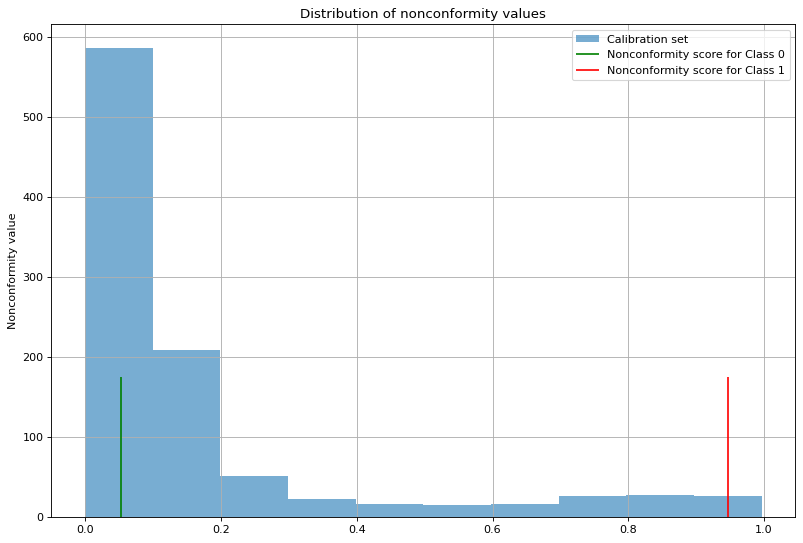

In [54]:
# plot distribution of nonconformity score for both situations

plt.figure(figsize=(12, 8), dpi=80)
plt.hist(
    np.sort(non_conformity_scores_calibration),
    label='Calibration set',
    alpha=0.6
)
# single line
plt.vlines(
    x=non_conformity_scores_y_test_class_0, ymin=0, ymax=175, colors='green',
    label='Nonconformity score for Class 0'
)

plt.vlines(
    x=non_conformity_scores_y_test_class_1, ymin=0, ymax=175, colors='red',
    label='Nonconformity score for Class 1'
)

plt.grid(True)
plt.ylabel('Nonconformity value')
plt.title('Distribution of nonconformity values')

plt.legend(loc='upper right')
plt.show()

In [58]:
# Function computes prediction sets - here we essentially collect all the steps done above into one function
#  takes training set, test points, underlying classifier, significance level.
# Function returns for each test point, prediction sets and two sets of p-values for each potential label 0 & 1

def prediction_sets(
        X_train, y_train, X_calib, y_calib,
        X_test, y_test, model=LogisticRegression(),
        significance_level=0.05
):
    prediction_sets = []
    p_values_class_0 = []
    p_values_class_1 = []

    model.fit(X_train, y_train)

    # make point predictions and get class scores on the calibration and test sets
    y_pred_calib = model.predict(X_calib)
    y_pred_score_calib = model.predict_proba(X_calib)

    y_pred_test = model.predict(X_test)
    y_pred_score_test = model.predict_proba(X_test)

    for i, y in enumerate(y_test):
        # compute nonconformity scores for each test trying both potential labels - 0 & 1
        non_conformity_scores_y_test_class_0 = 1 - y_pred_score_test[i, 0]
        non_conformity_scores_y_test_class_1 = 1 - y_pred_score_test[i, 1]

        non_conformity_scores_calib_plus_test_0 = np.append(
            non_conformity_scores_calibration,
            non_conformity_scores_y_test_class_0
        )

        # compute p-value of the test point twice, each time assigning potential label 0 and 1
        p_value_class_0 = compute_p_values(
            non_conformity_scores_calib_plus_test_0,
            non_conformity_scores_y_test_class_0
        )
        p_value_class_1 = compute_p_values(
            non_conformity_scores_calib_plus_test_0,
            non_conformity_scores_y_test_class_1
        )

        p_values_class_0.append(p_value_class_0)
        p_values_class_1.append(p_value_class_1)

        if (p_value_class_0 > significance_level) and (p_value_class_1 > significance_level):
            prediction_sets.append([True, True])
        elif (p_value_class_0 > significance_level) and (p_value_class_1 <= significance_level):
            prediction_sets.append([True, False])
        elif (p_value_class_0 <= significance_level) and (p_value_class_1 > significance_level):
            prediction_sets.append([False, True])
        else:
            prediction_sets.append([False, False])

    return prediction_sets, p_values_class_0, p_values_class_1

In [59]:
predictions_test_sets, p_values_test_set_class_0, p_values_test_set_class_1 = prediction_sets(
    X_train, y_train, X_calib,
    y_calib, X_test, y_test,
    model=LogisticRegression(),
    significance_level=0.05
)


In [60]:
predictions_test_sets[:20]

[[True, False],
 [True, False],
 [True, False],
 [True, True],
 [True, False],
 [True, True],
 [True, False],
 [True, False],
 [True, False],
 [True, False],
 [True, False],
 [True, False],
 [True, True],
 [True, False],
 [True, False],
 [True, True],
 [True, False],
 [True, False],
 [True, False],
 [True, False]]

In [61]:
# Let's build Inductive Conformal Predictor (ICP) using open source library nonconformist https://github.com/donlnz/nonconformist

#nc = NcFactory.create_nc(model,err_func=InverseProbabilityErrFunc())	# Create a default nonconformity function, this is the inverse probability (hinge loss) nonconformity measure we used above

icp = IcpClassifier(
    ClassifierNc(
        ClassifierAdapter(
            LogisticRegression()
        ),
        MarginErrFunc()
    )
)

In [50]:
# Fit the ICP using the proper training set
icp.fit(X_train, y_train)

# Calibrate the ICP using the calibraiton set
icp.calibrate(X_calib, y_calib)

In [51]:
icp

IcpClassifier(condition=<function BaseIcp.__init__.<locals>.<lambda> at 0x7fcfc3206320>,
              nc_function=ClassifierNc(err_func=<nonconformist.nc.MarginErrFunc object at 0x7fcfc2e4b160>,
                                       model=ClassifierAdapter(fit_params={},
                                                               model=LogisticRegression())))

In [52]:
# Produce predictions for the test set, with confidence 95%
prediction = icp.predict(X_test.values, significance=0.05)

In [53]:
prediction.shape

(1000, 2)

In [54]:
prediction[:20:]

array([[ True, False],
       [ True, False],
       [ True, False],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True,  True],
       [ True, False],
       [ True, False],
       [ True,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False]])

In [55]:
y_test

34262    0
25171    0
11426    0
22639    1
34917    0
        ..
7791     0
30960    0
23800    0
29208    0
9604     0
Name: class, Length: 1000, dtype: int64

In [56]:
# Here we output prediction sets we constructed manually by writing code from scratch and comparing it with the output from Nonconformist. The results are the same.
for i in range(len(predictions_test_sets)):
    print(predictions_test_sets[i], prediction[i, :])

[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, False] [ True False]
[True, True] [ True  True]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]
[True, False] [ True False]

In [57]:
assert (predictions_test_sets, prediction)